In [1]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, List, Tuple

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from alns import ALNS, State
from alns.accept import RecordToRecordTravel, SimulatedAnnealing
from alns.select import AlphaUCB
from alns.stop import MaxIterations, MaxRuntime

In [2]:
%matplotlib inline

In [3]:
SEED = 2345

# The permutation flow shop problem
This notebook is largely based on [Stützle and Ruiz (2018)](https://iridia.ulb.ac.be/IridiaTrSeries/link/IridiaTr2018-006.pdf).

In the permutation flow shop problem (PFSP), a set of jobs $N=\{1, \dots, n\}$ has to be processed on a set of machines $M = \{1, \dots, m\}$. Every job $j$ requires a processing time $p_{ij}$ on machine $i$. Moreover, all $n$ jobs have to be processed in the same order on every machine, and, the jobs follow the same machine order, starting from machine $1$ and ending at machine $m$. The objective is to find a permutation of the jobs, describing the order in which they are processed, such that the maximum completion time is minimized. This is also known as minimizing the *makespan*.

In this notebook, we demonstrate how to use ALNS to solve the permutation flow shop problem (PFSP), which is known to be NP-hard. In particular, we will implement the Iterated Greedy algorithm by [Ruiz and Stützle (2007)](https://www.sciencedirect.com/science/article/abs/pii/S0377221705008507?casa_token=V1QrcrUlY_QAAAAA:Vg3ADRaLM7-AaOu2DAo7P0sLatwnNF4LWEnB6K9OqjtQtYNqEW4YTnOAmIz227byWa2LEE3939s), which is a crossover between large neighborhood search and iterated local search. We will also cover some advanced features of the `alns` package, including autofitting the acceptance criterion, adding local search to greedy repair, and using the `**kwargs` argument in `ALNS.iterate` to test different destroy rates.



## Data
The [Taillard instances](http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/ordonnancement.html) are the most used benchmark instances for the permutation flow shop problem. We will use the `tai_50_20_8` instance, which consists of 50 jobs and 20 machines.

In [4]:
@dataclass
class Data:
    n_jobs: int
    n_machines: int
    bkv: int # best known value
    processing_times: np.ndarray

with open("tai50_20_8.txt", 'r') as fi:
    lines = fi.readlines()
    
    n_jobs, n_machines, _, bkv, _ = [int(num) for num in lines[1].split()]
    processing_times = np.genfromtxt(lines[3:], dtype=int)
    data = Data(n_jobs, n_machines, bkv, processing_times)

Let's plot a Gantt chart of a random schedule.

In [5]:
def compute_completion_times(schedule):
    """
    Compute the completion time for each job of the passed-in schedule.
    """
    completion = np.zeros(data.processing_times.shape, dtype=int)

    for pos, job in enumerate(schedule):
        for machine in range(data.n_machines):
            prev_job = (
                completion[machine, schedule[pos - 1]] if pos != 0 else 0
            )
            prev_machine = completion[machine - 1, job] if machine != 0 else 0
            processing = data.processing_times[machine, job]

            completion[machine, job] = max(prev_job, prev_machine) + processing

    return completion


def compute_makespan(schedule):
    """
    Returns the makespan, i.e., the maximum completion time.
    """
    return compute_completion_times(schedule)[-1, schedule[-1]]

In [6]:
def plot(schedule, name):
    n_machines, n_jobs = data.processing_times.shape

    completion = compute_completion_times(schedule)
    start = completion - data.processing_times

    # Plot each job using its start and completion time
    cmap = cm.get_cmap("rainbow", n_jobs)
    machines, length, start_job, job_colors = zip(
        *[
            (i, data.processing_times[i, j], start[i, j], cmap(j - 1))
            for i in range(n_machines)
            for j in range(n_jobs)
        ]
    )

    _, ax = plt.subplots(1, figsize=(12, 6))
    ax.barh(machines, length, left=start_job, color=job_colors)

    ax.set_title(f"Schedule for {name}\n Makespan: {compute_makespan(schedule)}") 
    ax.set_ylabel(f"Machines")
    ax.set_xlabel(f"Time")

    plt.show()

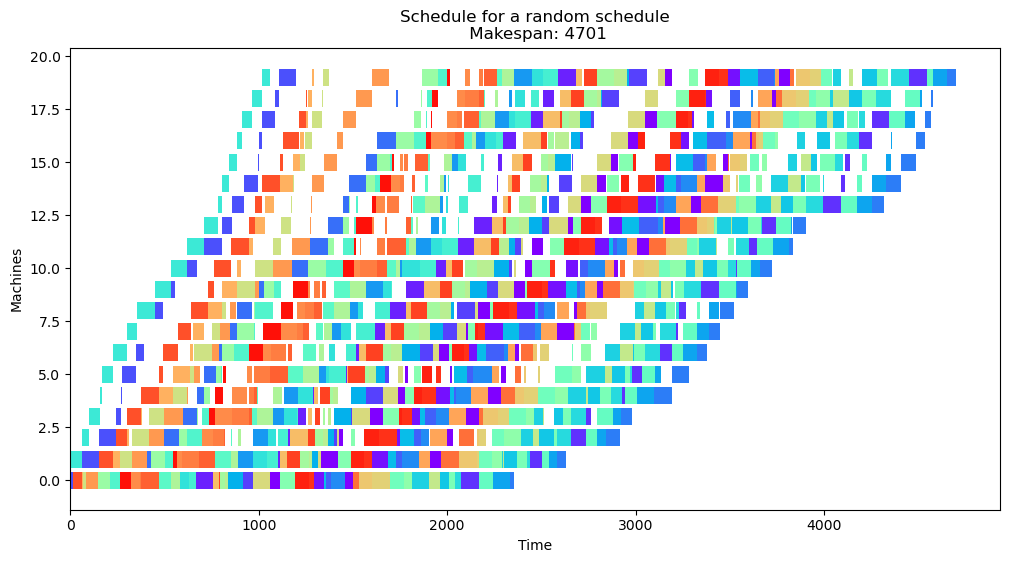

In [7]:
plot(rnd.choice(range(data.n_jobs), size=data.n_jobs, replace=False), 'a random schedule')

## Solution state

In [8]:
class Solution(State):
    def __init__(self, schedule: List[int], unassigned: Optional[List[int]] = None):
        self.schedule = schedule
        self.unassigned = unassigned if unassigned is not None else []
        self._makespan = None

    def objective(self):
        return compute_makespan(self.schedule)

    def insert(self, job: int, idx: int):
        self.schedule.insert(idx, job)

    def opt_insert(self, job: int):
        """
        Optimally insert the job in the current schedule.
        """
        idcs_costs = all_insert_cost(self.schedule, job)
        idx, _ = min(idcs_costs, key=lambda idx_cost: idx_cost[1])
        self.insert(job, idx)

    def remove(self, job: int):
        self.schedule.remove(job)

A key component in ruin-and-recreate algorithms is a fast way to compute the best insertion place for an unassigned job. In the PFSP, a naive approach is to try all $O(n)$ insertion positions and compute for each the resulting makespan in $O(nm)$ time. This has total time complexity $O(n^2m)$. A more efficient way is to use [Taillard's acceleration](https://scholar.google.com/citations?view_op=view_citation&hl=nl&user=vj-4SjYAAAAJ&citation_for_view=vj-4SjYAAAAJ:IjCSPb-OGe4C), which is a labeling algorithm that reduces this operation to only $O(nm)$.

In [9]:
def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:
    """
    Computes the partial makespans when inserting a job in the schedule.
    O(nm) using Taillard's acceleration. Returns a list of tuples of insertion
    index and the resulting makespan.
    
    [1] Taillard, E. (1990). Some efficient heuristic methods for the
    flow shop sequencing problem. European Journal of Operational Research,
    47(1), 65-74.
    """
    k = len(schedule) + 1
    m = data.processing_times.shape[0]
    p = data.processing_times

    # Earliest completion times of job pi(j) on machine i before inserting the new job
    e = np.zeros((m + 1, k))
    for j in range(k - 1):
        for i in range(m):
            e[i, j] = max(e[i, j - 1], e[i - 1, j]) + p[i, schedule[j]]

    # Duration between starting time and final makespan
    q = np.zeros((m + 1, k))
    for j in range(k - 2, -1, -1):
        for i in range(m - 1, -1, -1):
            q[i, j] = max(q[i + 1, j], q[i, j + 1]) + p[i, schedule[j]]

    # Earliest relative completion time
    f = np.zeros((m + 1, k))
    for l in range(k):
        for i in range(m):
            f[i, l] = max(f[i - 1, l], e[i, l - 1]) + p[i, job]

    # Partial makespan; drop the last (dummy) row of q
    M = np.max(f + q, axis=0)

    return [(idx, M[idx]) for idx in np.argsort(M)]

## Destroy operators
We implement two destroy operators: a random job removal operator, and an adjacent job removal operator. Both destroy operators rely on the `n_remove` parameter, which should inferred from the `**kwargs` argument. We will show later how we can experiment with different values for `n_remove`.

In [10]:
def random_removal(state: Solution, rnd_state, **kwargs) -> Solution:
    """
    Randomly remove a number jobs from the solution. The default number of jobs
    to remove is 2. If `n_remove` is passed as keyword argument, use that value
    instead.
    """
    destroyed = deepcopy(state)

    for job in rnd_state.choice(
        data.n_jobs, kwargs.get("n_remove", 2), replace=False
    ):
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed

In [11]:
def adjacent_removal(state: Solution, rnd_state, **kwargs) -> Solution:
    """
    Randomly remove a number adjacent jobs from the solution. The default
    number of jobs to remove is 2. If `n_remove` is passed as keyword argument,
    use that value instead.
    """
    destroyed = deepcopy(state)
    
    n_remove = kwargs.get("n_remove", 2)
    start = rnd_state.randint(data.n_jobs - n_remove)
    jobs_to_remove = [state.schedule[start + idx] for idx in range(n_remove)]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed

## Repair operator
We implement a greedy repair operator, which uses a specific ordering for the unassigned jobs. We first insert the jobs with the highest total processing times first. This is also known as the *NEH ordering*, which is also used for the initial solution (see next subsection).

In [12]:
def greedy_repair(state: Solution, rnd_state, **kwargs) -> Solution:
    """
    Greedily insert the unassigned jobs back into the schedule. The jobs are
    inserted in non-decreasing order of total processing times.
    """
    state.unassigned.sort(key=lambda j: sum(data.processing_times[:, j]))

    while len(state.unassigned) != 0:
        job = state.unassigned.pop()  # largest total processing time first
        state.opt_insert(job)

    return state

## Initial solution

In [13]:
def NEH(processing_times: np.ndarray) -> Solution:
    """
    Schedules jobs in decreasing order of the total processing times.

    [1] Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983). A heuristic algorithm
    for the m-machine, n-job flow-shop sequencing problem. Omega, 11(1), 91-95.
    """
    largest_first = np.argsort(processing_times.sum(axis=0)).tolist()[::-1]
    solution = Solution([largest_first.pop(0)], [])

    for job in largest_first:
        solution.opt_insert(job)

    return solution

In [14]:
init = NEH(data.processing_times)
objective = init.objective()
pct_diff = 100 * (objective - data.bkv) / bkv

print(f"Initial solution objective is {objective}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bkv}.")

Initial solution objective is 3929.
This is 5.9% worse than the optimal solution, which is 3709.


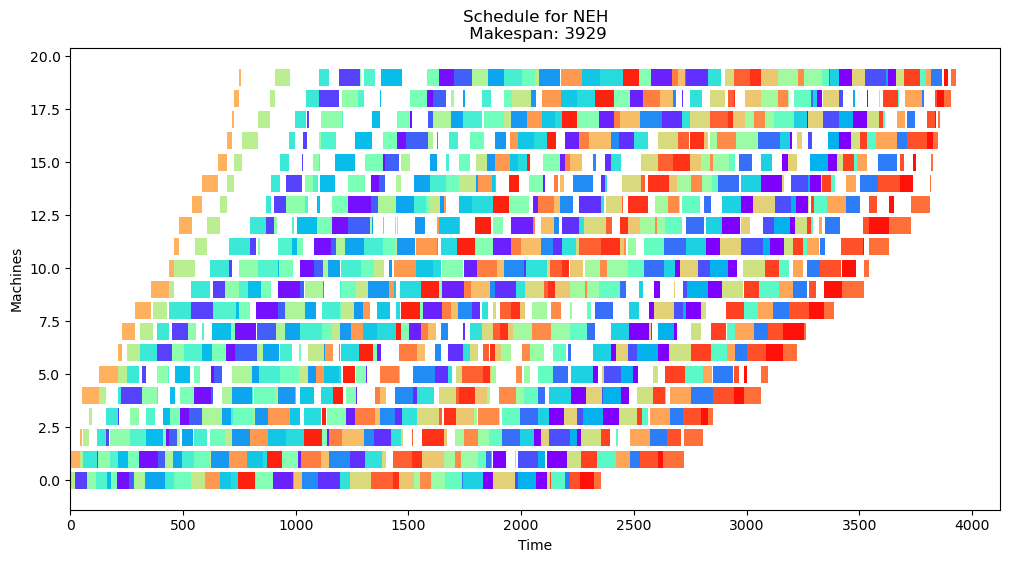

In [15]:
plot(init.schedule, "NEH")

## Heuristic solution

In [16]:
alns = ALNS(rnd.RandomState(SEED))

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(adjacent_removal)

alns.add_repair_operator(greedy_repair)

In [17]:
ITERS = 8000

init = NEH(data.processing_times)
select = AlphaUCB(
    scores=[5, 2, 1, 0.5],
    alpha=0.10,
    num_destroy=len(alns.destroy_operators),
    num_repair=len(alns.repair_operators),
)
stop = MaxIterations(ITERS)

### Autofitting acceptance criteria
To use the simulated annealing criterion, we need to determine three parameters: 1) the start temperature, 2) the final temperature and 3) the updating step. These parameters are often calculated using the following procedure:
- Start temperature is set to a specific value, such that a new candidate solution, which is 5% worse than the initial solution, is accepted with 50% probability.
- Final temperature is set to 1.
- The updating step is set to the linear/exponential growth rate that is needed to decrease from the start temperature to the final temperature in the specified number of iterations.

Because this is such a common procedure, the `SimulatedAnnealing` class exposes an `autofit` that can determine these parameters automatically. See the [documentenation](https://alns.readthedocs.io/en/latest/accept.html#alns.accept.SimulatedAnnealing.SimulatedAnnealing.autofit) for more information.

In [18]:
accept = SimulatedAnnealing.autofit(init.objective(), 0.02, 0.50, ITERS)

In [19]:
result = alns.iterate(init, select, accept, stop)

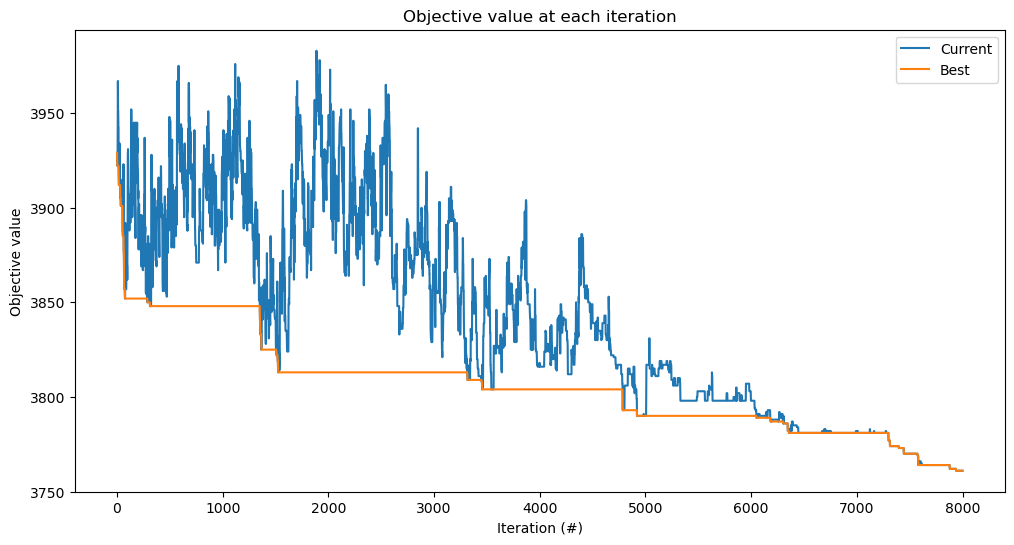

In [20]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [21]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - data.bkv) / bkv

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bkv}.")

Best heuristic objective is 3761.
This is 1.4% worse than the optimal solution, which is 3709.


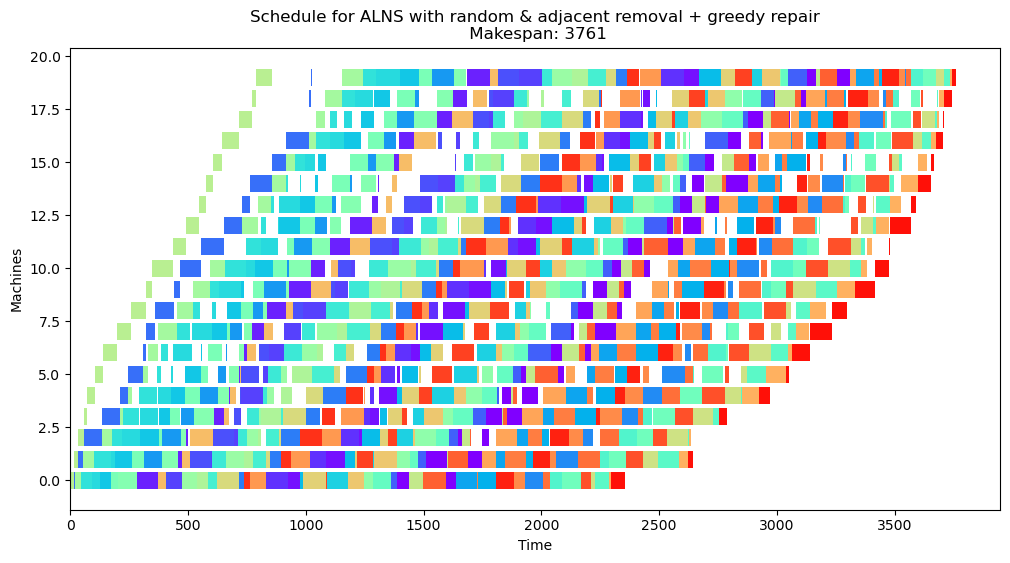

In [22]:
plot(result.best_state.schedule, "ALNS with random & adjacent removal + greedy repair")

### Adding local search to the greedy repair step

It's quite common to apply a local search after the repair step. This is also at the core of the iterated greedy algorithm (and iterated local search). 

There are various ways to do this. As explained in the [documentation](https://alns.readthedocs.io/en/latest/other%20single-trajectory%20heuristics.html#ils), one could implement a perturbation and local search operator and pass this to ALNS as destroy and repair operator, respectively. We do it slightly different: we add the local search in the greedy repair function.

In [23]:
def greedy_repair_then_local_search(state: Solution, rnd_state, **kwargs):
    """
    Greedily insert the unassigned jobs back into the schedule. Apply local
    search afterwards.
    """
    state = greedy_repair(state, rnd_state, **kwargs)
    local_search(state, **kwargs)
    return state


def local_search(solution: Solution, **kwargs):
    """
    Improves the current solution in-place using the insertion neighborhood.
    A random job is selected and put in the best new position. This continues
    until relocating any of the jobs leads to an improving move.
    """
    improved = True

    while improved:
        improved = False
        current = solution.objective()

        for job in rnd.choice(
            solution.schedule, len(solution.schedule), replace=False
        ):
            solution.remove(job)
            solution.opt_insert(job)

            if solution.objective() < current:
                improved = True
                current = solution.objective()
                break

In [24]:
alns = ALNS(rnd.RandomState(SEED))

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(adjacent_removal)

alns.add_repair_operator(greedy_repair_then_local_search)

In [25]:
ITERS = 300 # Less iterations because local search is expensive

init = NEH(data.processing_times)
select = AlphaUCB(
    scores=[5, 2, 1, 0.5],
    alpha=0.10,
    num_destroy=len(alns.destroy_operators),
    num_repair=len(alns.repair_operators),
)
accept = SimulatedAnnealing.autofit(init.objective(), 0.05, 0.50, ITERS)
stop = MaxIterations(ITERS)

result = alns.iterate(init, select, accept, stop)

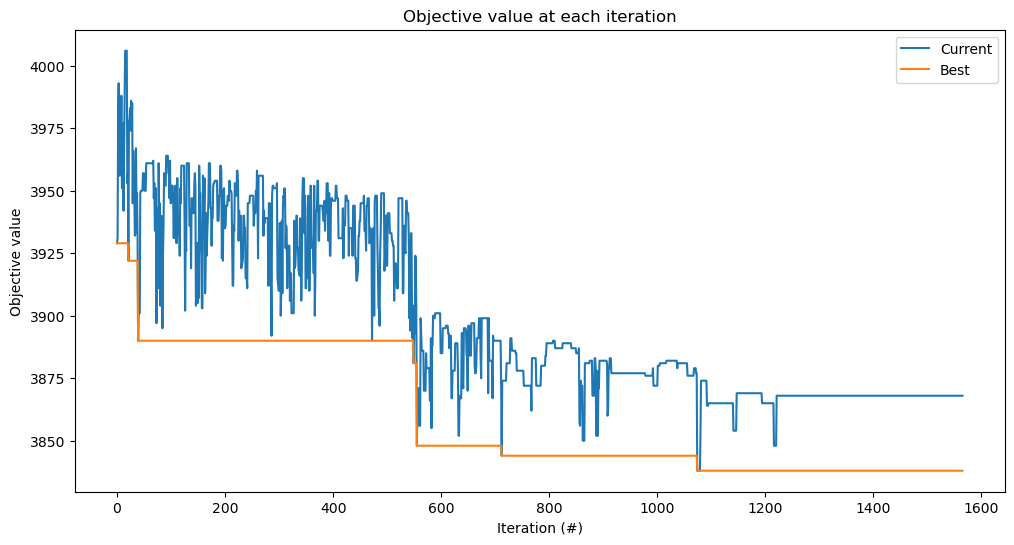

In [32]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [27]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - data.bkv) / bkv

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bkv}.")

Best heuristic objective is 3814.
This is 2.8% worse than the optimal solution, which is 3709.


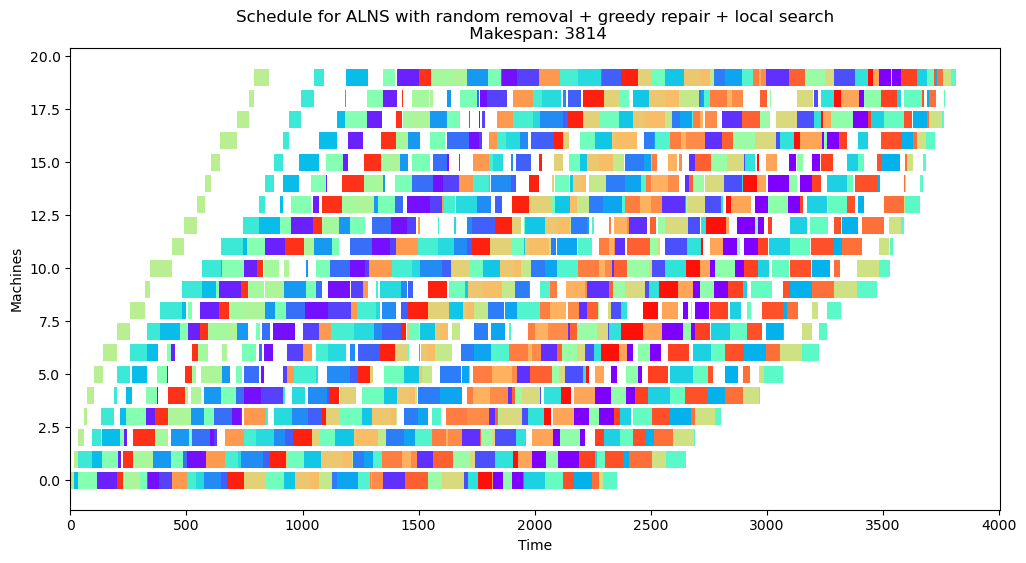

In [28]:
name = "ALNS with random removal + greedy repair + local search"
plot(result.best_state.schedule, name)

The inclusion of local search does not lead to a better solutions on this specific instance. Despite our result, it has been shown by [Stützle and Ruiz (2018)](https://iridia.ulb.ac.be/IridiaTrSeries/link/IridiaTr2018-006.pdf) that the inclusion of local search is important to obtain state-of-the-art solutions with iterated greedy.

### Tuning the destroy rate
We mentioned earlier that we can pass keyword-arguments to `ALNS.iterate`. This can be helpful when we want to pass-on parameters to the destroy/repair operators. In our case, we want to test for which value of `n_destroy` we obtain the best results.

In [29]:
alns = ALNS(rnd.RandomState(SEED))

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(adjacent_removal)

alns.add_repair_operator(greedy_repair)

In [30]:
objectives = {}

for n_remove in range(2, 10):
    iters = ITERS / (n_remove * 2) # higher destroy rates should use less iterations
    select = AlphaUCB(
        scores=[5, 2, 1, 0.5],
        alpha=0.10,
        num_destroy=len(alns.destroy_operators),
        num_repair=len(alns.repair_operators),
    )
    accept = RecordToRecordTravel.autofit(init.objective(), 0.02, 0.00, 2000)
    stop = MaxRuntime(30)
    result = alns.iterate(init, select, accept, stop, n_remove=n_remove)
    objectives[n_remove] = result.best_state.objective()
    
print(objectives)

{2: 3836, 3: 3781, 4: 3775, 5: 3804, 6: 3818, 7: 3830, 8: 3842, 9: 3838}


Text(0.5, 0, 'n_destroy')

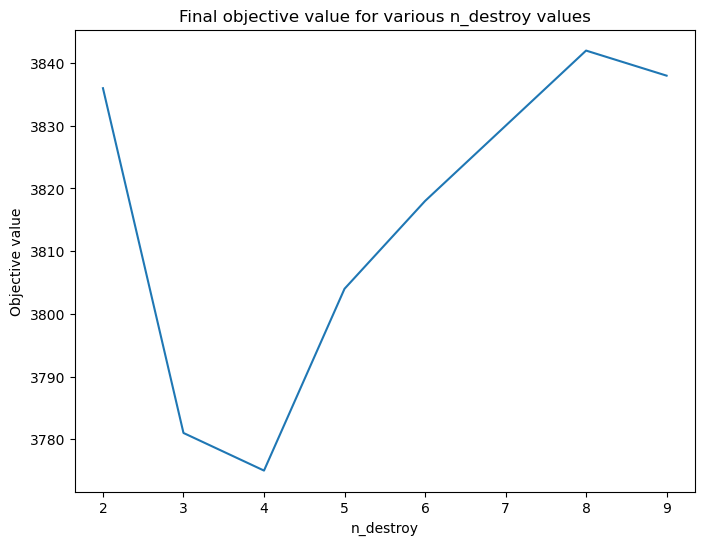

In [31]:
fig, ax = plt.subplots(figsize=[8, 6])

ax.plot(*zip(*sorted(objectives.items())))
ax.set_title("Final objective value for various n_destroy values")
ax.set_ylabel("Objective value")
ax.set_xlabel("n_destroy")

From this simple experiment, it looks like a destroy rate of 3-4 works best.

## Conclusions
In this notebook, we implemented the several variants of adaptive large neighborhood search to solve the permutation flow shop problem. We obtained a solution that is only 1.4% worse than the best known solution. Furthermore, we showed several advanced features in ALNS, including:
- Autofitting acceptance criteria
- Adding local search to repair procedures
- Tuning the destroy rate using the `**kwargs` argument in `ALNS.iterate`

